# Finding Dory
## Politecnico di Milano, Internet of Things + Wireless Internet project
### Processing and localization

In the fist part of this project we have collected from the CoAP and MQTT server a total of 180 fingerprints and Dory's RSSI. In this part of the project we analyze the data and localize Dory using fingerprint-based methods.


## Importing data

The fist step is importing the retrieved data and set it up in a format suitable for analysis. In this section we import the data by parsing with simple custom parsers the hand-crafted text files and convert the entire dataset into a standard dataframe, suitable for further analysis.

In [448]:
import ast
import pandas as pd
pd.set_option('display.max_rows', 50)
import numpy as np
from numpy.ma.core import log10
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, ConfusionMatrixDisplay

np.random.seed(31415)

### Import data from CoAP

In [449]:
data_coap = []
with open("coap/coap_coords.txt") as f:
  for l in f:
    row = []
    ls = l.split("||")

    # extract ground truth position
    pos = list(map(int, map(float,ls[0].split(","))))

    # parse list and integer literals as python lists
    anchors_readings = []
    for anchor_readings in ls[1:]:
      anchors_readings.append(list(map(ast.literal_eval , ast.literal_eval(anchor_readings.strip()))))
    
    # unroll experiments into one row per experiment
    # appending ground truth and one station per column
    for exp_idx in range(len(anchors_readings[0])):
      row = pos[:] + [exp_idx]
      for anchor_idx in range(len(anchors_readings)):

        row.append(anchors_readings[anchor_idx][exp_idx])
      data_coap.append(row)
  
  # build df
  df_coap = pd.DataFrame(data=data_coap, columns=["X", "Y", "exp_id", "A1", "A2", "A3", "A4", "A5", "A6"])

### Import data from MQTT

In [450]:
data_mqtt = []
with open("mqtt/mqtt_coords.txt") as f:
  for l in f:
    row = []
    ls = l.split("|")

    # extract ground truth position
    pos = list(map(int, map(float,ls[0].split(","))))

    # parse list and integet literals as python lists
    anchors_readings = []
    for anchor_readings in ls[1:]:
      anchors_readings.append(list(map(int , anchor_readings.strip().split(","))))
    
    # unroll experiments into one row per experiment
    # appending ground truth and one station per column
    for exp_idx in range(len(anchors_readings[0])):
      row = pos[:] + [exp_idx]
      for anchor_idx in range(len(anchors_readings)):
        #print(anchors_readings[anchor_idx])
        row.append(anchors_readings[anchor_idx][exp_idx])
      data_mqtt.append(row)
  
  # build df
  df_mqtt = pd.DataFrame(data=data_mqtt, columns=["X", "Y", "exp_id", "A1", "A2", "A3", "A4", "A5", "A6"])

### Merging the two data sets plus Dory's RSSI

In [451]:
df = pd.concat([df_coap, df_mqtt])

# manually define Dory's RSSI
Dory_RSSI = [-57,-63,-58,-64,-63,-66]
Dory_RSSI_np = np.array(Dory_RSSI)

# dataset constraints to check if the data is valid
assert(len(df) == 6*6*5)
assert(df.isna().sum().sum() == 0)

display(df)

,X,Y,exp_id,A1,A2,A3,A4,A5,A6
0,10,6,0,-64,-64,-61,-59,-59,-55
1,10,6,1,-60,-60,-57,-55,-55,-51
2,10,6,2,-62,-61,-58,-56,-57,-53
3,10,6,3,-66,-66,-63,-61,-61,-57
4,10,6,4,-64,-64,-61,-59,-59,-55
...,...,...,...,...,...,...,...,...,...
65,8,4,0,-59,-61,-54,-55,-57,-56
66,8,4,1,-66,-67,-61,-60,-63,-63
67,8,4,2,-64,-65,-59,-58,-61,-61
68,8,4,3,-65,-66,-60,-59,-62,-62


## Data analysis

We will show two analysis approaches.
* pure mathematical: we aggregate all samples from the same position via averaging, fill  in missing values with linear and bilinear interpolation, compute the euclidean distances of all produced data points from the reference RSSI and selecting the minimum distance one
* Machine Learning: we use all available fingerprints to train a KNN model, which we then use to classify the reference RSSI; the produced results are aggregated with a truncated weighted average.

### Pure mathematical approach
Note: the Machine learning approach is documented [in this file](knn.ipynb) (`knn.ipynb`).

#### Aggregating data and dealing with missing values
Let us average all readings for an anchor at a position and build a dataframe of mean readings.

In [452]:
means_data = []
for x in range(0,11,2):
    for y in range(0,11,2):
      row = [x,y]
      row += df.loc[(df['X'] == x) & (df['Y'] == y)].mean()[["A1", "A2","A3","A4","A5","A6"]].values.tolist()
      means_data.append(row)
df_means = pd.DataFrame(data=means_data, columns=['X', 'Y', "A1", "A2", "A3", "A4", "A5", "A6"])
display(df_means)

,X,Y,A1,A2,A3,A4,A5,A6
0,0,0,-26.8,-66.6,-61.0,-66.8,-67.6,-69.8
1,0,2,-51.4,-63.2,-59.8,-65.4,-64.6,-67.4
2,0,4,-56.8,-60.4,-60.6,-65.4,-62.4,-66.0
3,0,6,-61.4,-58.2,-64.4,-67.2,-62.0,-66.4
4,0,8,-61.2,-49.6,-64.0,-65.6,-58.2,-64.0
5,0,10,-66.0,-23.6,-65.2,-67.0,-58.0,-64.0
6,2,0,-52.6,-66.6,-56.0,-65.0,-66.8,-68.6
7,2,2,-54.4,-63.2,-56.4,-62.6,-63.8,-66.2
8,2,4,-58.2,-61.2,-59.2,-64.2,-61.8,-65.2
9,2,6,-62.0,-59.2,-61.6,-65.6,-60.0,-64.8


#### Interpolation
Let us now perform linear and bilinear interpolation to produce a new dataframe. The new dataframe has only one sample per `(x,y)` position.
* if the position was in the original dataframe, the corresponding entry is the average of the entries in the original dataframe (mean)
* if the position was not in the original dataframe and its adjacent positions were present, the corresponding entry is the average of the adjacent entries from the original dataframe (linear interpolation)
* if the position was not in the original dataframe and its adjacent positions were also not present, the corresponding entry is the average of the adjacent entries computed in the new dataframe dataframe (bilinear interpolation)

In [453]:
# row-based
df_interpolation = df_means.copy()
for x in range(1,10,2):
  for y in range(0,11,2):

    row = pd.DataFrame(df_interpolation.loc[((df_interpolation['X'] == (x - 1)) |
                                       (df_interpolation['X'] == (x + 1))) &
                                       (df_interpolation['Y'] == y)].mean(axis=0).dropna()).transpose()
    df_interpolation = pd.concat([df_interpolation, pd.DataFrame(row)])


# column-based
for x in range(0,11,1):
  for y in range(1,10,1):

    if not df_interpolation.loc[(df_interpolation['X'] == x) &
                                (df_interpolation['Y'] == y)].empty:
      continue
    row = pd.DataFrame(df_interpolation.loc[((df_interpolation['Y'] == (y - 1)) |
                                       (df_interpolation['Y'] == (y + 1))) &
                                       (df_interpolation['X'] == x)].mean(axis=0).dropna()).transpose()
    df_interpolation = pd.concat([df_interpolation, pd.DataFrame(row)])

display(df_interpolation)

,X,Y,A1,A2,A3,A4,A5,A6
0,0.0,0.0,-26.8,-66.6,-61.0,-66.8,-67.6,-69.8
1,0.0,2.0,-51.4,-63.2,-59.8,-65.4,-64.6,-67.4
2,0.0,4.0,-56.8,-60.4,-60.6,-65.4,-62.4,-66.0
3,0.0,6.0,-61.4,-58.2,-64.4,-67.2,-62.0,-66.4
4,0.0,8.0,-61.2,-49.6,-64.0,-65.6,-58.2,-64.0
...,...,...,...,...,...,...,...,...
0,10.0,1.0,-64.3,-66.8,-58.7,-37.5,-65.0,-63.5
0,10.0,3.0,-65.3,-66.7,-60.4,-54.3,-64.3,-61.8
0,10.0,5.0,-65.0,-65.3,-61.2,-58.2,-61.3,-58.0
0,10.0,7.0,-64.1,-63.0,-61.1,-59.5,-57.8,-51.6


We can plot the computed signal strength curved to visually inspect for any evident mistake.

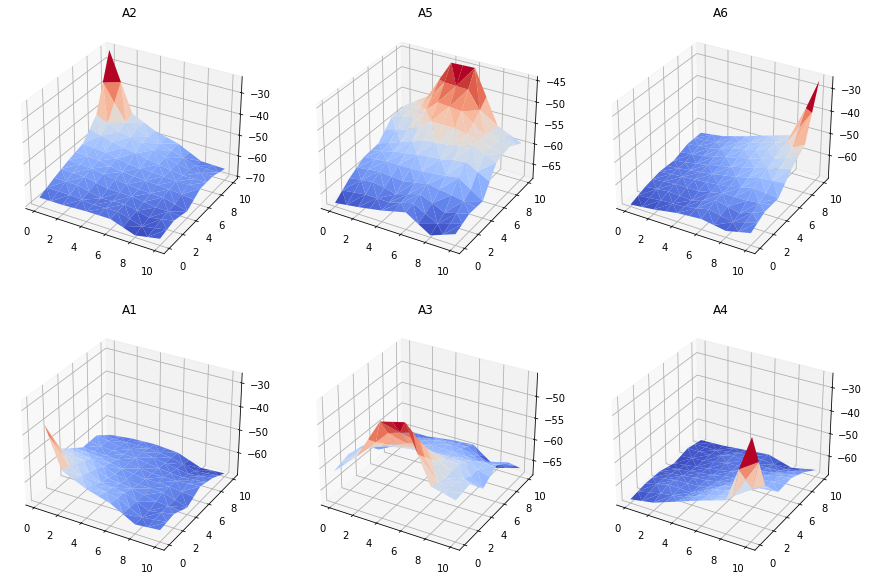

In [454]:
fig = plt.figure(figsize=(15,10))
fig.patch.set_facecolor('xkcd:white')

for idx, station in enumerate(["A2","A5","A6","A1","A3","A4",]):
  data = df_interpolation[["X","Y",station]].values
  x, y, z = data[:,0], data[:,1], data[:,2]
  ax = fig.add_subplot(2,3,(idx % 6)+ 1, projection='3d')
  ax.set_title(station)
  ax.plot_trisurf(x, y, z, linewidth=0.2, antialiased=True, cmap=cm.coolwarm)

The plots above shows reasonable signals for wifi RSSI propagation.

#### Euclidean Distance
Now that we have managed average the values of repeated measurements and to approximate the missing ones, we can compute the Euclidean distance of each fingerprint in the interpolated dataframe from the Dory RSSI sample.

In [455]:
def compute_euclidean_distance(row):
  return np.linalg.norm(Dory_RSSI_np - row[["A1", "A2", "A3", "A4", "A5", "A6"]])

df_interpolation['Euclidean Distance'] = df_interpolation.apply(compute_euclidean_distance, axis=1)

display(df_interpolation.nsmallest(10, 'Euclidean Distance', 'all'))

,X,Y,A1,A2,A3,A4,A5,A6,Euclidean Distance
0,2.0,3.0,-56.3,-62.20,-57.80,-63.4,-62.80,-65.7,1.288410
0,3.0,3.0,-58.6,-63.35,-57.05,-63.2,-63.10,-65.7,2.079663
0,1.0,3.0,-55.2,-62.00,-59.00,-64.4,-63.15,-66.2,2.337199
8,2.0,4.0,-58.2,-61.20,-59.20,-64.2,-61.80,-65.2,2.870540
0,1.0,4.0,-57.5,-60.80,-59.90,-64.8,-62.10,-65.6,3.210919
7,2.0,2.0,-54.4,-63.20,-56.40,-62.6,-63.80,-66.2,3.464102
0,3.0,2.0,-57.2,-64.60,-55.40,-62.8,-64.40,-66.6,3.622154
0,3.0,4.0,-60.0,-62.10,-58.70,-63.6,-61.80,-64.8,3.652396
2,0.0,4.0,-56.8,-60.40,-60.60,-65.4,-62.40,-66.0,3.984972
0,0.0,3.0,-54.1,-61.80,-60.20,-65.4,-63.50,-66.7,4.170132


Visual inspection of the smallest computed euclidean distances shows reasonable values and clustering around similar coordinates.

This method selects the position **(2,3)**

Repeating the same operation for the original dataframe, with no interpolation and all individual samples, shows coherent results.

In [456]:
df['Euclidean Distance'] = df.apply(compute_euclidean_distance, axis=1)
display(df.nsmallest(10, 'Euclidean Distance', 'all'))

,X,Y,exp_id,A1,A2,A3,A4,A5,A6,Euclidean Distance
48,2,4,3,-58,-61,-59,-64,-62,-65,2.828427
47,2,4,2,-58,-61,-59,-64,-61,-65,3.316625
85,2,2,0,-54,-63,-56,-63,-64,-66,3.872983
53,0,4,3,-57,-61,-61,-66,-63,-66,4.123106
87,2,2,2,-54,-61,-56,-63,-63,-65,4.358899
21,4,4,1,-61,-62,-57,-62,-61,-64,5.477226
54,0,4,4,-58,-62,-62,-67,-64,-68,5.656854
89,2,2,4,-53,-62,-55,-62,-62,-65,5.656854
33,4,2,3,-58,-64,-53,-61,-63,-65,6.082763
34,4,2,4,-59,-65,-53,-62,-64,-66,6.164414


In [457]:
df = df.drop(columns='Euclidean Distance')
df_interpolation = df_interpolation.drop(columns='Euclidean Distance')

df.to_csv("data/raw_data.csv", index=False)
df_interpolation.to_csv("data/processed_data.csv", index=False)

,X,Y,exp_id,A1,A2,A3,A4,A5,A6
0,10,6,0,-64,-64,-61,-59,-59,-55
1,10,6,1,-60,-60,-57,-55,-55,-51
2,10,6,2,-62,-61,-58,-56,-57,-53
3,10,6,3,-66,-66,-63,-61,-61,-57
4,10,6,4,-64,-64,-61,-59,-59,-55
...,...,...,...,...,...,...,...,...,...
65,8,4,0,-59,-61,-54,-55,-57,-56
66,8,4,1,-66,-67,-61,-60,-63,-63
67,8,4,2,-64,-65,-59,-58,-61,-61
68,8,4,3,-65,-66,-60,-59,-62,-62


,X,Y,A1,A2,A3,A4,A5,A6
0,0.0,0.0,-26.8,-66.6,-61.0,-66.8,-67.6,-69.8
1,0.0,2.0,-51.4,-63.2,-59.8,-65.4,-64.6,-67.4
2,0.0,4.0,-56.8,-60.4,-60.6,-65.4,-62.4,-66.0
3,0.0,6.0,-61.4,-58.2,-64.4,-67.2,-62.0,-66.4
4,0.0,8.0,-61.2,-49.6,-64.0,-65.6,-58.2,-64.0
...,...,...,...,...,...,...,...,...
0,10.0,1.0,-64.3,-66.8,-58.7,-37.5,-65.0,-63.5
0,10.0,3.0,-65.3,-66.7,-60.4,-54.3,-64.3,-61.8
0,10.0,5.0,-65.0,-65.3,-61.2,-58.2,-61.3,-58.0
0,10.0,7.0,-64.1,-63.0,-61.1,-59.5,-57.8,-51.6
